In [2]:
# Step 1: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Step 2: Load Dataset from Google Drive
from google.colab import files
uploaded = files.upload()

# Load the dataset (Replace 'customer_behavior_analytics.csv' with your actual filename)
df = pd.read_csv("/content/customer_behavior_analytcis.csv")

# Step 3: Data Exploration
print(df.info())
print(df.head())

# Step 4: Handle Missing Values
# Select only numeric columns for median calculation
numeric_df = df.select_dtypes(include=np.number)
numeric_df.fillna(numeric_df.median(), inplace=True)
# Update the original DataFrame with the filled values
df[numeric_df.columns] = numeric_df

# Step 5: Drop Unnecessary Columns
df.drop(columns=['customer_id'], inplace=True)  # Removing customer ID since it's not needed

# Step 6: Check for Duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate Rows: {duplicate_rows}")
df = df.drop_duplicates()

# Step 7: Detect and Remove Outliers Using Z-Score
z_scores = np.abs(zscore(df))
outlier_threshold = 3  # Typically, a Z-score above 3 is considered an outlier
outliers = (z_scores > outlier_threshold).sum(axis=0)
print(f"Outliers per column: \n{outliers}")

# Remove outliers
df_cleaned = df[(z_scores < outlier_threshold).all(axis=1)]

# Step 8: Summary Statistics After Cleaning
print(df_cleaned.describe())

# Save Cleaned Data
df_cleaned.to_csv("cleaned_customer_behavior.csv", index=False)
print("Cleaned dataset saved as 'cleaned_customer_behavior.csv'")

Saving customer_behavior_analytcis.csv to customer_behavior_analytcis (2).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB
None
   total_purchases  avg_cart_value  total_time_spent  product_click  \
0              7.0          129.34             52.17           18.0   
1             22.0           24.18              9.19           15.0   
2              2.0           32.18             90.69           50.0   
3             25.0           26.85             11.22           16.0   
4              7.0          1

In [3]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the cleaned dataset
file_path = "cleaned_customer_behavior.csv"  # Update this with your file path
df = pd.read_csv(file_path)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to all numerical columns
df_scaled = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Display first few rows
df_scaled.head()


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
0,-0.648133,0.990423,0.081431,-0.630402,-0.960384
1,1.520804,-0.933613,-1.230992,-0.816082,0.630567
2,-1.371111,-0.787243,1.257664,1.350184,-0.505827
3,1.954591,-0.884762,-1.169004,-0.754189,1.312403
4,-0.648133,0.919250,-0.467600,0.112318,-0.278548


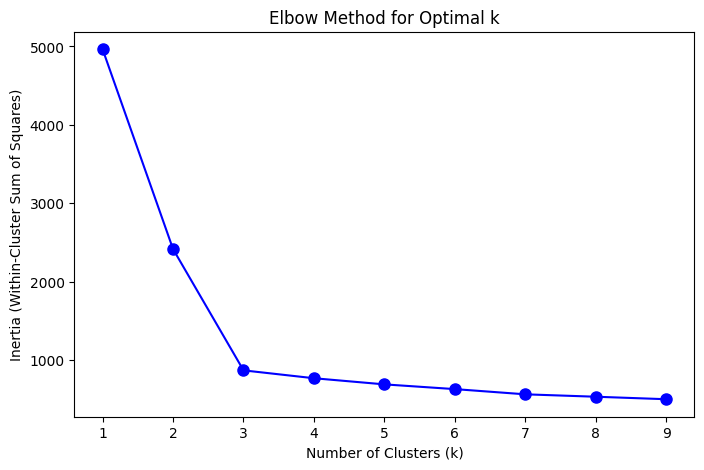

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K = range(1, 10)  # Checking for clusters from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [5]:
# Choose the optimal number of clusters (from the Elbow Method, e.g., k=3)
optimal_k = 3  # Update based on the Elbow plot

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_scaled["Cluster"] = kmeans.fit_predict(df_scaled)

# Display first few rows with cluster labels
df_scaled.head()


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,Cluster
0,-0.648133,0.990423,0.081431,-0.630402,-0.960384,1
1,1.520804,-0.933613,-1.230992,-0.816082,0.630567,2
2,-1.371111,-0.787243,1.257664,1.350184,-0.505827,0
3,1.954591,-0.884762,-1.169004,-0.754189,1.312403,2
4,-0.648133,0.919250,-0.467600,0.112318,-0.278548,1


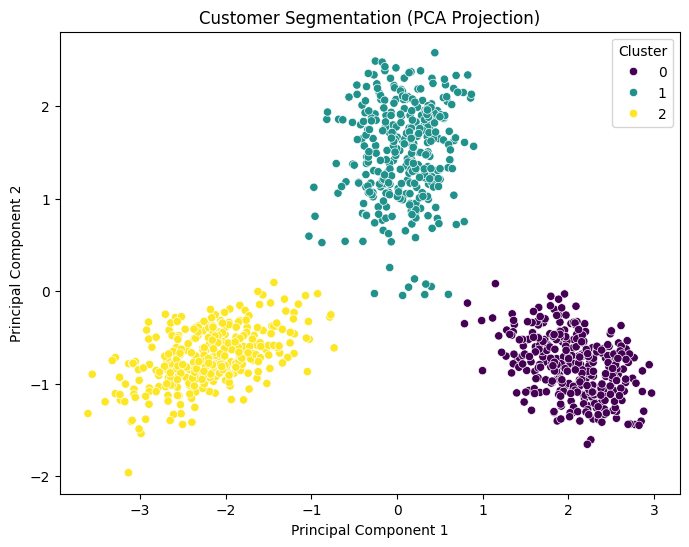

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled.iloc[:, :-1])  # Exclude the cluster column

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = df_scaled["Cluster"]

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="viridis")
plt.title("Customer Segmentation (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


In [7]:
# Compute mean feature values for each cluster
cluster_summary = df.groupby(df_scaled["Cluster"]).mean()

# Display the cluster characteristics
cluster_summary


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
Cluster,,,,,
0,4.924699,49.034066,90.211837,49.370482,1.027108
1,10.170659,144.687874,40.472126,19.925150,1.940120
2,19.480122,30.813456,17.396697,15.113150,9.807339


In [8]:
# Save the dataset with cluster labels
df_scaled.to_csv("segmented_customers.csv", index=False)

print("Clustered dataset saved successfully!")


Clustered dataset saved successfully!
